In [1]:
!git clone https://github.com/facebookresearch/detectron2.git
%cd detectron2

Cloning into 'detectron2'...
remote: Enumerating objects: 15725, done.
remote: Counting objects: 100% (448/448), done.
remote: Compressing objects: 100% (337/337), done.
remote: Total 15725 (delta 201), reused 301 (delta 102), pack-reused 15277
Receiving objects: 100% (15725/15725), 6.51 MiB | 12.51 MiB/s, done.
Resolving deltas: 100% (11317/11317), done.
/content/detectron2


In [2]:
!pip install -e .

Obtaining file:///content/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=3fe715f372a9a298851f1e16d789f9e73f527a0b5234d6c0e61db681b944cbba
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=aa3e9356b64d5a0381f33e22f8087bd9e6f8ada37e8f1f75

In [1]:
%cd detectron2

/content/detectron2


In [ ]:
!curl -L "https://universe.roboflow.com/ds/aXCl44gHQv?key=DUmgcIGjco" --output roboflow.zip && unzip roboflow.zip -d car_logos && rm roboflow.zip

In [2]:
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from google.colab.patches import cv2_imshow
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
import torch

import os
import random
import json
import numpy as np
import cv2

from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [3]:
if torch.cuda.is_available():
  generator = torch.Generator('cuda').manual_seed(25)
else:
  generator = torch.Generator().manual_seed(25)

In [4]:
register_coco_instances("car_logos_train", {}, "/content/detectron2/car_logos/train/_annotations.coco.json", "/content/detectron2/car_logos/train")
register_coco_instances("car_logos_val", {}, "/content/detectron2/car_logos/valid/_annotations.coco.json", "/content/detectron2/car_logos/valid")
register_coco_instances("car_logos_test", {}, "/content/detectron2/car_logos/test/_annotations.coco.json", "/content/detectron2/car_logos/test")

my_dataset_train_metadata = MetadataCatalog.get("car_logos_train")
dataset_dicts = DatasetCatalog.get("car_logos_train")

WARNING [06/06 19:41:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/06 19:41:34 d2.data.datasets.coco]: Loaded 8010 images in COCO format from /content/detectron2/car_logos/train/_annotations.coco.json


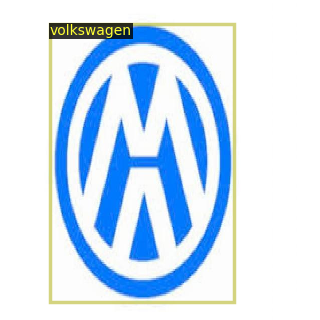

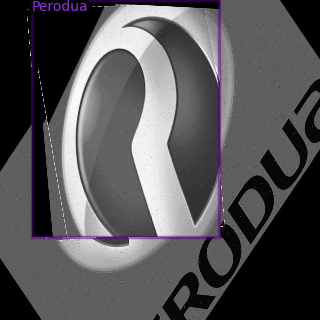

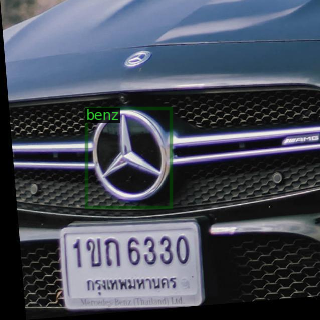

In [5]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("car_logos_train",)
cfg.DATASETS.TEST = ("car_logos_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #adjust up if val mAP is still rising, adjust down if overfit
# cfg.SOLVER.STEPS = (1000, 1200)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(my_dataset_train_metadata.thing_classes)

cfg.TEST.EVAL_PERIOD = 500

In [7]:
class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [8]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = 1
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/06 19:41:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:01, 105MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[06/06 19:41:45 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/06 19:41:56 d2.utils.events]:  eta: 0:08:10  iter: 19  total_loss: 3.892  loss_cls: 3.739  loss_box_reg: 0.09087  loss_rpn_cls: 0.02688  loss_rpn_loc: 0.01273    time: 0.3245  last_time: 0.3106  data_time: 0.0160  last_data_time: 0.0092   lr: 1.9981e-05  max_mem: 2670M
[06/06 19:42:05 d2.utils.events]:  eta: 0:08:00  iter: 39  total_loss: 3.134  loss_cls: 2.87  loss_box_reg: 0.1296  loss_rpn_cls: 0.04416  loss_rpn_loc: 0.01766    time: 0.3213  last_time: 0.3692  data_time: 0.0084  last_data_time: 0.0086   lr: 3.9961e-05  max_mem: 2671M
[06/06 19:42:11 d2.utils.events]:  eta: 0:07:54  iter: 59  total_loss: 1.097  loss_cls: 0.9557  loss_box_reg: 0.1227  loss_rpn_cls: 0.02927  loss_rpn_loc: 0.01307    time: 0.3197  last_time: 0.3360  data_time: 0.0084  last_data_time: 0.0087   lr: 5.9941e-05  max_mem: 2671M
[06/06 19:42:18 d2.utils.events]:  eta: 0:07:46  iter: 79  total_loss: 0.3713  loss_cls: 0.2427  loss_box_reg: 0.1228  loss_rpn_cls: 0.02665  loss_rpn_loc: 0.01235    time: 0.3171 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/06 19:44:34 d2.evaluation.evaluator]: Inference done 11/840. Dataloading: 0.0012 s/iter. Inference: 0.0338 s/iter. Eval: 0.0003 s/iter. Total: 0.0353 s/iter. ETA=0:00:29
[06/06 19:44:39 d2.evaluation.evaluator]: Inference done 151/840. Dataloading: 0.0014 s/iter. Inference: 0.0342 s/iter. Eval: 0.0003 s/iter. Total: 0.0359 s/iter. ETA=0:00:24
[06/06 19:44:44 d2.evaluation.evaluator]: Inference done 289/840. Dataloading: 0.0014 s/iter. Inference: 0.0344 s/iter. Eval: 0.0003 s/iter. Total: 0.0361 s/iter. ETA=0:00:19
[06/06 19:44:49 d2.evaluation.evaluator]: Inference done 428/840. Dataloading: 0.0014 s/iter. Inference: 0.0344 s/iter. Eval: 0.0003 s/iter. Total: 0.0361 s/iter. ETA=0:00:14
[06/06 19:44:54 d2.evaluation.evaluator]: Inference done 569/840. Dataloading: 0.0014 s/iter. Inference: 0.0343 s/iter. Eval: 0.0003 s/iter. Total: 0.0360 s/iter. ETA=0:00:09
[06/06 19:44:59 d2.evaluation.evaluator]: Inference done 708/840. Dataloading: 0.0014 s/iter. Inference: 0.0343 s/iter. Eval: 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/06 19:47:45 d2.evaluation.evaluator]: Inference done 11/840. Dataloading: 0.0012 s/iter. Inference: 0.0378 s/iter. Eval: 0.0003 s/iter. Total: 0.0394 s/iter. ETA=0:00:32
[06/06 19:47:50 d2.evaluation.evaluator]: Inference done 148/840. Dataloading: 0.0014 s/iter. Inference: 0.0350 s/iter. Eval: 0.0003 s/iter. Total: 0.0367 s/iter. ETA=0:00:25
[06/06 19:47:55 d2.evaluation.evaluator]: Inference done 285/840. Dataloading: 0.0014 s/iter. Inference: 0.0348 s/iter. Eval: 0.0003 s/iter. Total: 0.0366 s/iter. ETA=0:00:20
[06/06 19:48:00 d2.evaluation.evaluator]: Inference done 424/840. Dataloading: 0.0014 s/iter. Inference: 0.0347 s/iter. Eval: 0.0003 s/iter. Total: 0.0365 s/iter. ETA=0:00:15
[06/06 19:48:06 d2.evaluation.evaluator]: Inference done 563/840. Dataloading: 0.0014 s/iter. Inference: 0.0346 s/iter. Eval: 0.0003 s/iter. Total: 0.0364 s/iter. ETA=0:00:10
[06/06 19:48:11 d2.evaluation.evaluator]: Inference done 701/840. Dataloading: 0.0014 s/iter. Inference: 0.0346 s/iter. Eval: 

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/06 19:51:00 d2.evaluation.evaluator]: Inference done 11/840. Dataloading: 0.0010 s/iter. Inference: 0.0343 s/iter. Eval: 0.0003 s/iter. Total: 0.0356 s/iter. ETA=0:00:29
[06/06 19:51:05 d2.evaluation.evaluator]: Inference done 150/840. Dataloading: 0.0014 s/iter. Inference: 0.0344 s/iter. Eval: 0.0003 s/iter. Total: 0.0361 s/iter. ETA=0:00:24
[06/06 19:51:10 d2.evaluation.evaluator]: Inference done 289/840. Dataloading: 0.0014 s/iter. Inference: 0.0344 s/iter. Eval: 0.0003 s/iter. Total: 0.0361 s/iter. ETA=0:00:19
[06/06 19:51:15 d2.evaluation.evaluator]: Inference done 428/840. Dataloading: 0.0014 s/iter. Inference: 0.0344 s/iter. Eval: 0.0003 s/iter. Total: 0.0361 s/iter. ETA=0:00:14
[06/06 19:51:20 d2.evaluation.evaluator]: Inference done 565/840. Dataloading: 0.0014 s/iter. Inference: 0.0345 s/iter. Eval: 0.0003 s/iter. Total: 0.0362 s/iter. ETA=0:00:09
[06/06 19:51:25 d2.evaluation.evaluator]: Inference done 704/840. Dataloading: 0.0014 s/iter. Inference: 0.0345 s/iter. Eval: 

In [10]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [12]:
!cp -r /content/detectron2/output /content/drive/MyDrive/cmp719_project/detectrons/car_logos

In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[06/06 19:52:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


WARNING [06/06 19:52:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/06 19:52:34 d2.data.datasets.coco]: Loaded 840 images in COCO format from /content/detectron2/car_logos/valid/_annotations.coco.json


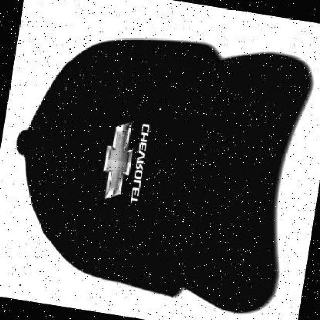

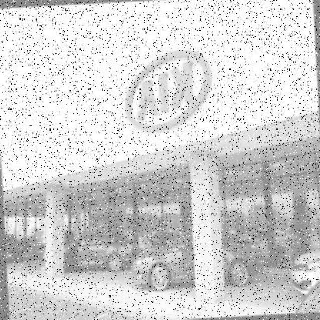

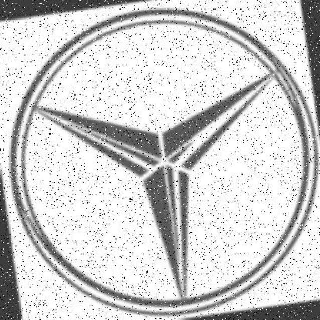

In [14]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("car_logos_val")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_dataset_train_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [15]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("car_logos_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "car_logos_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [06/06 19:52:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/06 19:52:36 d2.data.datasets.coco]: Loaded 840 images in COCO format from /content/detectron2/car_logos/valid/_annotations.coco.json
[06/06 19:52:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/06 19:52:36 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/06 19:52:36 d2.data.common]: Serializing 840 elements to byte tensors and concatenating them all ...
[06/06 19:52:36 d2.data.common]: Serialized dataset takes 0.24 MiB
[06/06 19:52:36 d2.evaluation.evaluator]: Start inference on 840 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/06 19:52:37 d2.evaluation.evaluator]: Inference done 11/840. Dataloading: 0.0010 s/iter. Inference: 0.0335 s/iter. Eval: 0.0001 s/iter. Total: 0.0346 s/iter. ETA=0:00:28
[06/06 19:52:42 d2.evaluation.evaluator]: Inference done 149/840. Dataloading: 0.0014 s/iter. Inference: 0.0347 s/iter. Eval: 0.0001 s/iter. Total: 0.0362 s/iter. ETA=0:00:25
[06/06 19:52:47 d2.evaluation.evaluator]: Inference done 290/840. Dataloading: 0.0014 s/iter. Inference: 0.0344 s/iter. Eval: 0.0001 s/iter. Total: 0.0359 s/iter. ETA=0:00:19
[06/06 19:52:52 d2.evaluation.evaluator]: Inference done 431/840. Dataloading: 0.0014 s/iter. Inference: 0.0343 s/iter. Eval: 0.0001 s/iter. Total: 0.0358 s/iter. ETA=0:00:14
[06/06 19:52:57 d2.evaluation.evaluator]: Inference done 571/840. Dataloading: 0.0014 s/iter. Inference: 0.0343 s/iter. Eval: 0.0001 s/iter. Total: 0.0358 s/iter. ETA=0:00:09
[06/06 19:53:02 d2.evaluation.evaluator]: Inference done 712/840. Dataloading: 0.0014 s/iter. Inference: 0.0342 s/iter. Eval: 